# 2022 Social Networks and Health Workshop
Example of `mossspider` presented at the Duke Network Analysis Center's 2022 Social Networks and Health Workshop.

First, we will load libraries used throughout

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import mossspider
from mossspider import NetworkTMLE
from mossspider.dgm import uniform_network, generate_observed

print("versions")
print("==================")
print("MossSpider:", mossspider.__version__)
print("NumPy:     ", np.__version__)
print("pandas:    ", pd.__version__)
print("NetworkX:  ", nx.__version__)

versions
MossSpider: 0.0.2
NumPy:      1.19.5
pandas:     1.1.5
NetworkX:   2.5.1


## Generating Data
Before the example, we need some data to use. We will use some built-in network and variable generators included in `mossspider`. The data generating mechanism is based on Sofrygin & van der Laan (2017).

The network here consists of $n=500$ and follows a uniform degree distribution. Degree values are between 1 to 4.

In [2]:
# Generating graph
G = uniform_network(n=500, degree=[1, 4],
                    seed=202205)

# Selecting out the largest component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = nx.convert_node_labels_to_integers(G.subgraph(Gcc[0]))

# Simulating covariates for largest component
H = generate_observed(G0, 
                      seed=202205)

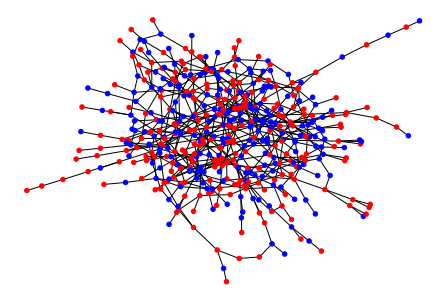

In [3]:
# Determine position for nodes
pos = nx.spring_layout(H, seed=202205)

# Color nodes by A
color_map = []                         # Empty list for colors
for node, data in H.nodes(data=True):  # For loop over nodes
    if data['A'] == 1:                 # If A=1   
        color_map.append('blue')       # ... set color to blue
    else:                              # If A=0
        color_map.append('red')        # ... set color to green

# Drawing network
nx.draw(H, 
        node_color=color_map,
        node_size=20, 
        pos=pos,
       )

In [4]:
# Examine assigned attributes to node i=0
print(H.nodes[0])

{'W': 0, 'A': 0, 'Y': 1}


In [5]:
# Describing covariates
w_var, a_var, y_var = [], [], []       # Temporary storage
for node, data in H.nodes(data=True):  # For loop over nodes
    w_var.append(data['W'])
    a_var.append(data['A'])
    y_var.append(data['Y'])


print("Summary info")
print("==================")
print("W:       {:.1%}".format(np.mean(w_var)))
print("A:       {:.1%}".format(np.mean(a_var)))
print("Y:       {:.1%}".format(np.mean(y_var)))

Summary info
W:       36.4%
A:       47.2%
Y:       67.7%


## Application of Network-TMLE
Having generated our data and done some preliminary examinations, we will move to applying network-TMLE. Here, we rely on the identification assumptions. Specifically, $A,A^s$ are independent of $Y(a,a^s)$ given $W,W^s$, causal consistency, positivity, the network is perfectly measured, and the correct parametric summary measures are known. Notice that these assumptions will require outside substantive knowledge.

With `mossspider`, network-TMLE is implemented in the `NetworkTMLE` class. The `NetworkTMLE` class must be first initialized with the input data, the attribute name for the exposure, and the attribute name for the outcome. `NetworkTMLE` expects the data to be provided in the form of a `networkx.Graph` object with all covariates assigned as node attributes. `NetworkTMLE` takes the input graph and extracts the adjacency matrix and the covariates. This internal processing of the graph object is to ensure that all summary measure calculations are done correctly.

Notice that `NetworkTMLE` does not handle missing data. Therefore, if any covariates have missing attributes or `np.nan` for an attribute, `NetworkTMLE` will noisily fail. 

Other major options for `NetworkTMLE` include: `verbose` (set to `True` to print all nuisance model fits), and `degree_restrict` (apply an upper and lower bound for degree, with inference no longer including those outside of the bounds. restricting by degree can improve performance with power-law degree distributions, but does change the corresponding inference since nodes outside are bounds are treated as the background and don't have their actions updated by the policy).

In [6]:
ntmle = NetworkTMLE(network=H,        # Providing data 
                    exposure='A',     # action label in H
                    outcome='Y',      # outcome label in H
                    verbose=False)    # display intermediate results         

After initialization of `NetworkTMLE`, we need to specify the nuisance models. 

### Exposure Nuisance Model
First we will specify the exposure nuisance model. As mentioned in the presentation, we factor the corresponding probabilities from the weights to
$$\Pr(A,A^s | W,W^s) = \Pr(A | W,W^s)\Pr(A^s | A,W,W^s)$$
Therefore, we need to specify two models. The `NetworkTMLE.exposure_model` function allows us to specify the model for $\Pr(A | W,W^s)$. In the background, a logistic model will later be used to estimate this probability. Here, $W_i^s = \sum_{j=1}^n W_j \mathcal{G}_{ij}$.

`NetworkTMLE.exposure_map_model` function specifies the model for $\Pr(A^s | A,W,W^s)$. In addition to the model form, we also need to specify what summary measure to use, as well as the distribution for the nuisance model. Here, we will use $A_i^s = \sum_{j=1}^n A_j \mathcal{G}_{ij}$ (internally stored as `A_sum` and specified via `sum`). Since this is a count, we will use a Poisson distribution for the nuisance model. 

Internally, `NetworkTMLE` stores this information for use during the later estimation procedure.

In [7]:
# Model for Pr(A | W, W^s; \delta)
ntmle.exposure_model(model="W + W_sum")          # Parametric model

# Model for Pr(A^s | A, W, W^s; \gamma)
ntmle.exposure_map_model(model='A + W + W_sum',  # Parametric model
                         measure='sum',          # Summary measure for A^s
                         distribution='poisson') # Model distribution to use

### Outcome Nuisance Model
Next, we need to specify the outcome nuisance model:
$$E[Y | A,A^s,W,W^s]$$
This is done via the `NetworkTMLE.outcome_model` function. This function expects the specification of the model and then interally estimates it using a generalized linear model. When $Y$ in binary, a logistic model is used. For continuous $Y$, the default is ordinary least squares but other options can be specified via the `distribution` optional argument.

Here, we model the outcomes using the sum summary measures for $A$ and $W$. Furthermore, they are modeled as linear with no interaction terms. In general, this is a fairly restrictive model. In practice, it is generally recommended to use more flexible model specifications.

In [8]:
# Model for E[Y | A, A^s, W, W^s; \alpha]
ntmle.outcome_model(model='A + A_sum + W + W_sum')

### Estimation
Having specified all the nuisance models, we can now estimate the parameter of interest. Here, we are interested in a few different stochastic policies, where policies designate how the action $A$ is assigned to the $n$ individuals in the network. Here, we consider policies which set the probability of the action, $\Pr(A_i)=\omega$ with $\omega \in \{0.1, 0.2, 0.3, ..., 0.8, 0.9\}$. 

For each policy $\omega$, we need to call the `NetworkTMLE.fit` function. The key part of `NetworkTMLE.fit` is the argument `p` which corresponds to the stochastic policy. This can be set as either a single float or a vector of floats. Here, we further specify the `samples` and `seed` optional arguments. The `samples` argument specifies how many re-samples of the data should be used in the Monte Carlo procedure (larger is better but increasing will lead to longer run-times). We also specify the `seed` argument to keep our answers consistent across re-runs of this script. 

After estimation, we can extract the point estimate via `NetworkTMLE.marginal_outcome`, and the confidence intervals via `NetworkTMLE.conditional_ci` and `NetworkTMLE.conditional_latent_ci`. Note that the first confidence interval assumes no latent dependence and the second allows for latent dependence up to 2nd order contacts. We will store the result for each $\omega$ to display in a plot

In [9]:
# Estimation
point = []                    # Storage for psi
lcl_d, ucl_d = [], []         # Storage for CI direct
lcl_l, ucl_l = [], []         # Storage for CI latent

# Policies to evaluate
policy = [0.1, 0.2, 0.3, 0.4, 0.5, 
          0.6, 0.7, 0.8, 0.9]

# Evaluating each policy
for p in policy:
    ntmle.fit(p=p,            # Policy
              samples=200,    # replicates for MC integration
              seed=20220316)  # seed for consistency
    # Saving output
    cid = ntmle.conditional_ci
    cil = ntmle.conditional_latent_ci
    point.append(ntmle.marginal_outcome)
    lcl_d.append(cid[0])
    lcl_l.append(cil[0])
    ucl_d.append(cid[1])
    ucl_l.append(cil[1])


Text(0, 0.5, '$\\psi$')

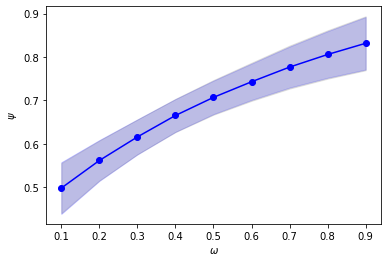

In [10]:
plt.plot(policy, point, 'o-', color='blue')
plt.fill_between(policy, lcl_d, ucl_d, color='blue', alpha=0.2)
plt.fill_between(policy, lcl_l, ucl_l, color='gray', alpha=0.2)
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\psi$")

This concludes the simple example. Please see other examples on the GitHub page or the ReadTheDocs site for further examples, details, and options.